In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import CrossEncoder
from models import *
from utils import *
import timeit

from IPython.display import Image

## 1. Création du data set

Les données sont extraites d'un fichier .json et sont séparées en deux data sets:  

- un premier contenant l'ensemble des contexts ainsi que leurs identifiants. ces identifiants sont codés par leur indice de position en commençant par la position 0.  

- un deuxième contenant les questions ainsi que les identifiants des contexts auquels ils sont liés. ceci permet d'eviter une répétition du contenu des contexts pour toutes les questions.    
    
Nous extrayons ces datasets et nous les stockons dans des fichiers .csv pour eviter de repeter le preocessus d'extraction.
Ceci est fait à l'aide de la fonction **get_data** de utils.py

In [2]:
X_question_train = pd.read_csv('Data/train_data/train_questions.csv')
X_context_train = pd.read_csv('Data/train_data/train_contexts.csv')

Visualisation des données

In [13]:
X_question_train.head()

,question,id_context
0,To whom did the Virgin Mary allegedly appear i...,0
1,What is in front of the Notre Dame Main Building?,0
2,The Basilica of the Sacred heart at Notre Dame...,0
3,What is the Grotto at Notre Dame?,0
4,What sits on top of the Main Building at Notre...,0


In [14]:
X_context_train.head()

,id_context,text_context
0,0,"Architecturally, the school has a Catholic cha..."
1,1,"As at most other universities, Notre Dame's st..."
2,2,The university is the major seat of the Congre...
3,3,The College of Engineering was established in ...
4,4,All of Notre Dame's undergraduate students are...


In [11]:
y_train = X_question_train['id_context']
X_question_train.drop(['id_context'], axis =1,inplace = True)
X_context_train.drop(['id_context'], axis = 1, inplace = True)

#contient les identifiants des contexts
context_id = X_context_train.index

## 2. Choix de la métrique d'évaluation des models

nous sommes face à un problème de ranking. Plusieurs mesures s'offrent à nous parmis lesquelles:  
- **MRR** (Mean Reciprocal Rank) : problème d'interpretabilité
- **top -k accuracy** : que nous avons choisi pour son interprétabilité

## 3. Les premiers models

Notre premiere approche est basée sur un calcul de similarité entre la question et les différents contexts passés en paramètre. 

Pour cela il nous faut:  
- sélectioner une méthode d'embedding pour la question et les paragragraphes  
- récuperer les documents les plus proches de la question à l'aide de l'algorithme **knn** avec la métrique **cosine**. 

C'est sur cette idée que se base nos deux models dit **basic_model** (cf models.py) à l'aide de deux type d'embedding:  
- un embedding réaliser grâce à TF-IDF
- un embedding réaliser grâce à des sentences transformers



### 3.1 Tfidf_model

#### a. Preprocessing
Le preprocessing pour ce model a été fait grâce aux paramètres de TF-IDF: 
- mettre en minuscule
- suppression de la ponctuation (automatique avec tfidf)
- retirer les stop words

Nous avons aussi essayer:  
- le stemming avec comme stemmer SnowballStemmer(language='english')
- la lemmatization avec comme lemmatizer WordNetLemmatizer()

Les résultats étaient tout juste légèrement améliorer pour beaucoup plus de temps de d'excécution vu la taille des contextes. Nous avons décidé ne pas les utiliser afin de minimiser le temps d'excécution de notre algorithme



#### b. Paramètres du Tfidfvectorizer
- **max_features=80000** : obtenu après un tuning  


- **binary = True**. Il permet de garder le terme tf (term frequence) du tf-idf à 1. Nous y avons pensé intuitivement car pour répondre à une question portant par exemple sur les types de stage à Illuin, un paragraphe comportant davantage le mot Illuin mais qui en réalité parle de la hiérachie à Illuin, n'est pas plus significatif qu'un paragraphe qui parle des stages en ne mentionnant le mot Illuin qu'une fois. Nous l'avons vérifié et avons effectivement observé une chute de performance du model

#### c. Le model
- Il est créé grâce à la classe Tfidf_model() de model.py
- Il réalise la prédiction des k meilleurs contexts à l'aide d'un algorithme knn fiter sur les embeddings des contexts passé en paramètres pour la création du modèle

#### d. Performance

In [13]:
# dictionnairee utilisé pour comparer les performances des différents models
dic_comparaison = {}


In [7]:
tfidf_model = Tfidf_model(X_context_train['text_context'], context_id, k = 20)
tfidf_model.fit()

L'evaluation est fait sur 5 batchs de taille 1000 choisis à chaque fois de façon aléatoire dans le dataset

In [8]:
accuracy_list = evaluate_model(tfidf_model, X_question_train['question'], y_train,iteration= 5, batch_size=1000)
dic_comparaison['tfidf'] = accuracy_list

batch 1 : accuracy top 1 = 0.581
batch 2 : accuracy top 1 = 0.552
batch 3 : accuracy top 1 = 0.591
batch 4 : accuracy top 1 = 0.581
batch 5 : accuracy top 1 = 0.589


le graphe trace les moyennes des résultats obtenus pour l'ensemble des batchs et ceux pour un accuracy de top1 à top 20

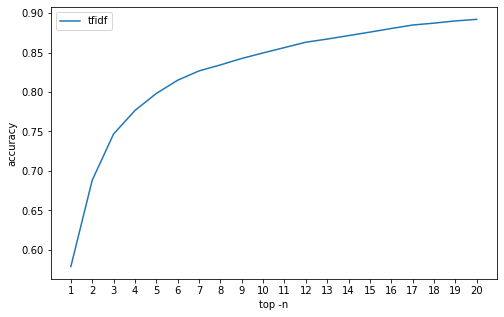

In [9]:
plot_accuracy(dic_comparaison, 20)

Notre modèle atteint une premiere performance d'environ 59% d'accuracy sur le top 1 et d'environ 90% pour le top 20. 
Ces premiers résulats nous ont suggérés plusieurs approches pour la suite:
- serait il possible d'utiliser les 20 premiers documents pour choisir le meilleur document ?
- serait il possible d'améliorer le top 20% et ensuite utilisé les 20 meilleurs documents pour choisir le meilleur document?

Les premières approches, pour répondre à la première question, utilisées étaient basées sur l'idée qu'en réduisant le vocabulaire aux mots les plus utiles pour répondre à la question, nous pouvions mieux selectionner le meilleur document.

- La première approche a été de selectionner les 20 meilleurs documents et de refaire un TF-IDF pour selectionner les trois meilleurs et ensuite de comparer cette approche à une approche où on selectionne directement les 3 meilleurs contextes. Nous avons observé une chute de performance  


- La deuxième approche a été de réduire progressivement la taille des contextes possibles: choisir les 20 premiers, puis refaire un TF-IDF pour choisir les 15 premiers, puis refaire un TF-IDF pour choisir les 10 premiers ainsi de suite (rythmé par une sorte de learning rate). Nous l'avons fait car nous estimions que le modèle éliminait très rapidement les meilleurs candidats. L'idée était de lui faire faire progressivement la différence entre les documents. Ce fût malheureusement un echec.

Suite à ces échecs nous nous sommes d'abord fixés pour objectif de commencer par améliorer l'accuracy du top 20.

### 3.2 Transformer_model

il est basé sur un SentenceTransformer conçu à l'aide de BERT qui nous donne un embedding de taille 384 pour les différents différents textes passés en paramètres

#### a. Preprocessing
Aucun preprocessing n'a été fait sur le texte avant de le passé au SentenceTransformer.  

Du fait du temps nécessaire à l'embedding de l'ensemble des contexts nous avons décidés de faire l'embedding des context du train_set et du dev_set et de le stocké dans des fichiers. On peut par la suite les charger dans des variables pour les reutiliser notemment dans le cadre des tests que nous réaliserons par la suite. nous les récupérons comme suit avec une fonction read_context_embedding de utils.py

In [14]:
 context_embedding = read_context_embedding('Data/train_data/train_context_embbeding_with_bert.csv')

In [15]:
context_embedding.shape

(18896, 384)

#### b. Paramètres du model
Le SentenceTransformer utilisé est le **SentenceTransformer('all-MiniLM-L6-v2')**  
Il prend aussi en entrée le context_embedding, l'index des différents contexts et le nombre k représentant les k meilleurs documents

#### c. Performance

L'évaluation est fait sur 5 batchs de taille 1000 choisis à chaque fois de façon aléatoire dans le dataset

In [11]:
# création du model
transformer_model = Transformer_model(context_embedding, X_context_train.index, 20)
transformer_model.fit()

In [12]:
accuracy_list = evaluate_model(transformer_model, X_question_train['question'], y_train,iteration= 5, batch_size=1000)
dic_comparaison['transformer'] = accuracy_list

batch 1 : accuracy top 1 = 0.622
batch 2 : accuracy top 1 = 0.59
batch 3 : accuracy top 1 = 0.6
batch 4 : accuracy top 1 = 0.575
batch 5 : accuracy top 1 = 0.591


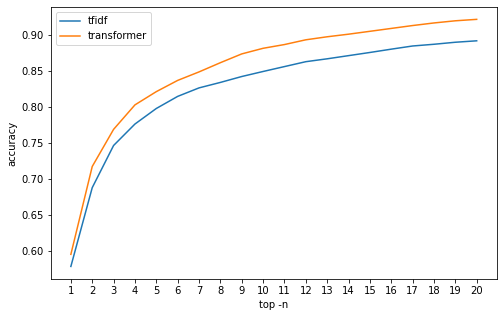

In [13]:
plot_accuracy(dic_comparaison, 20)

Les résultats obtenus à l'aide du SentenceTransformer sont meilleurs que ceux obtenus avec le TF-IDF.  
Cela nous à inspirer pour la suite:

Qu'obtiendrait ton en combinant les models ? 

En effet nous avons essayer de combiner de facon basique les deux models de la facon suivante : pour obtenir le top k du model issu de la combinaison on récupere les k//2 premiers proposés par le SentenceTransformer (k//2 + 1 si k est impaire donnant ainsi plus d'importance au Transformer_model) et les k//2 premiers obtenus par TF-IDF.

Nous n'avons pas directement refait l'expérience dans ce notebook mais voici les résultats obtenus

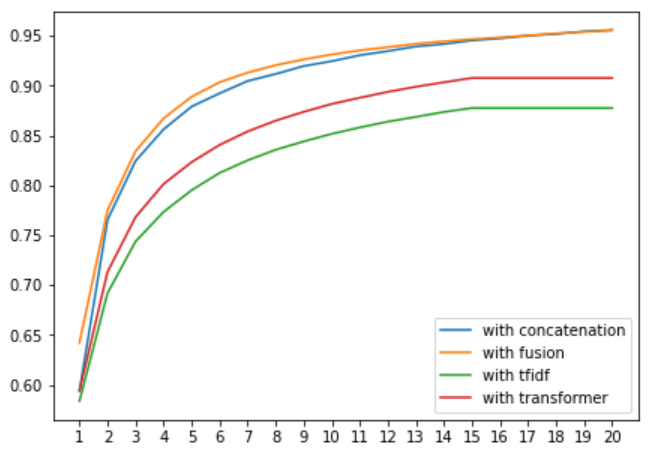

In [3]:
Image(filename = "images/fusion_comparaison.png", width = 450, height = 200)

Les résultats obtenus sont plutot satisfaisant pour le top 20. on atteint près de 95% sur le top 20.
le top 1 quant à lui reste faible on est pas loin de 60% pour la simple concatenation (courbe en bleu).

Nous avons donc decidé de tester afin d'ameliorer le top 20:  
- d'autres méthodes de fusion de model
- d'autres models basiques à developper pour faire des fusion.

Comme autre méthode de fusion nous avons utiliser une méthode basé sur les scores des prédictions deux models (tfidf et transformer). En effet en utilisant l'algorithme knn, on retourne les distances des différents documents à la question. On normalise ces vecteurs de scores obtenus par chaque model. Lors de la fusion, on récupère les k documents avec les scores les plus faibles et ceci sans répétition.  
pour s'assurer de bien obtenir k résultats à la fin de ce procédé nous réalisons des prédictions top k sur chaque modèle et noules fusionnons en 1 prédiction top k.

Les résultats de cette méthode de fusion ne diffère pas trop de la méthode basique (courbe en orange). 
et elle présente de nombreux inconvénients à priori.   
- on essaie de comparer les scores obtenus sur des vecteurs dimension différentes 384 contre 80000
- en le faisant on rompt l'équilibre qu'on essayait de créer en prenant autant de document prédit par TF-IDF que de document prédit par SentenceTransformer.

Cette analyse des limites de cette méthodes de fusion nous a mener à créer une troisième méthode de fusion sur laquelle nous reviendrons plus tard.



Nous avons essayer d'autres models afin de les fusionés à ceux que nous avons déjà mis en place.

- La première idée était basée sur le fait que dans un paragraphe la réponse à une question ne se trouve pas nécéssairement dans l'idée générale du texte mais bien dans une phrase de celui ci. nous avons donc essayer de séparer les contextes en phrases tout en gardant l'identifiant du context auquel elle est lié. la séparation en phrase a été fait à l'aide de sent_tokenize. Par la suite nous avons essayer un tfidf sur l'ensemble de toute les phrases. les résultats sont les suivants:

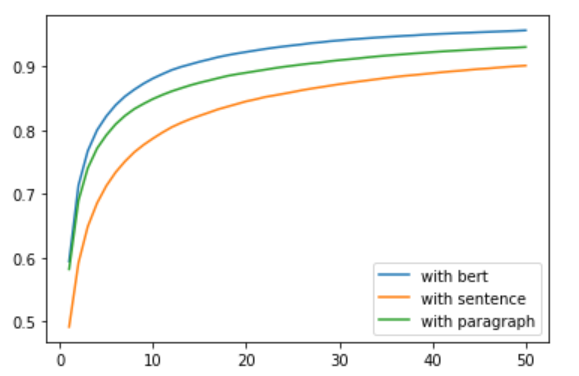

In [4]:
Image(filename = "images/sentence_comparaison.png", width = 450, height = 200)

Les résultats obtenus sont catastrophiques !!!  
Ce qui pourraient s'expliquer par le fait que lorsque le modèle choisi une phrase il y a de forete chance qu'il choisisse une autre phrase qui est dans le même paragraphe que la premiere ce qui crée un manque de diversité dans le modèle. Et remedier à ce problème de répétition aurait été assez difficiles surtout en utilisant l'algorithme knn.

Nous avons donc opté pour une autre approche: **BM25**

### 3.3 Bm25_model

Ici on calcule directement la similarité de la question avec chaque contexte sans faire un embedding initiale et sans utiliser knn.

#### a. Preprocessing

Le preprocessing pour ce model est fait grace à la fonction sentence_preocessing de utils.py. Elle permet de :  
- mettre en minuscule
- retirer les ponctuations
- retirer les stops words

Le temps d'excécution du calcul des scores de similarités avec bm25 est extrèmement élevé nous avons décidé de ne pas faire de lemmatization ou de stemming. De plus nous avons fait quelques tests sur l'influence de scores après lemmatization ou stemming, pas de changement alarmant.

#### b. Le model



En essayant de prédire des contextes pour large nombre de questions on s'est rendu compte que qu fait de la parralelisation utilisée pour l'exécution de BM25 le model ne fourni de score que lorsque l'ensemble des prédiction ont été réalisés ce qui occupent une enorme quanté d'espace et ralenti l'algorithme. Il semblait ne même plus progressé pour un nombre important de questions. Nous avons donc séparés les prédictions en batch de 1000.

#### c. Performance

L'évaluation est fait sur 5 batchs de taille 1000 choisis à chaque fois de façon aléatoire dans le dataset

In [14]:
bm25_model = BM25_model(X_context_train['text_context'], context_id, 20)
bm25_model.fit()

In [15]:
accuracy_list = evaluate_model(bm25_model, X_question_train['question'], y_train,iteration= 5, batch_size = 1000)
dic_comparaison['bm25'] = accuracy_list

batch 1 : accuracy top 1 = 0.671
batch 2 : accuracy top 1 = 0.705
batch 3 : accuracy top 1 = 0.673
batch 4 : accuracy top 1 = 0.685
batch 5 : accuracy top 1 = 0.657


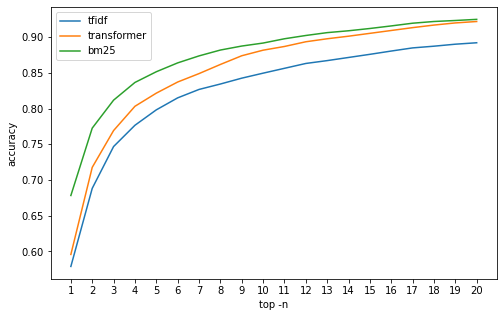

In [16]:
plot_accuracy(dic_comparaison, 20)

Les performances de BM25 sont nettement supérieurs aux prédiction des précedents modeles jusqu'au top 10. puis ses performances sont assez semblable à celle obtenu grâce au sentenceTransformer.

Nous avons aussi eu l'idée de combinés les trois modèles en utilisant une simple concatenation (pour une prédiction du top k, k//3 meilleurs prédictions de chacun des modèles, et en fonction des valeurs de k%3 nous prenions soit k//3 + 1 soit k//3 + 2 pour BM25 étant donné qu'il a de meilleurs performance )

Nous n'avons pas refait les expériences sur ce datasets mais les résultats obtenus sont:


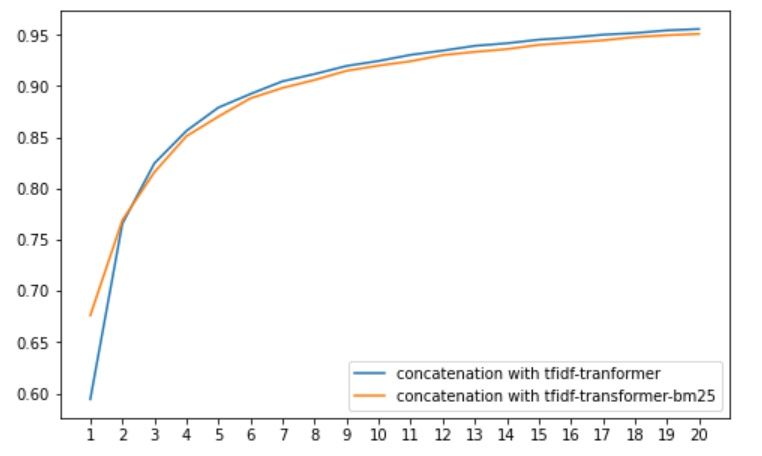

In [5]:
Image(filename = "images/bm25_comparaison.png", width = 450, height = 200)

On a de belles performances jusqu'au top 2 puis le model de concatenation des 3 rejoint celui de la concaténation tfidf - transformer.

Avec le modèle de simple concaténation de Tfidf_model et de Transformer_model nous avons un top 20 à 95%  
- Par la suite nous allons présenter une troisième méthode de fusion permettant de conserver l'équilibre en terme de nombre de prédiction selectionné pour chaque modèle et en évitant les répétions.  
- Ayant un top 20 assez intérréssant, nous avons preférez le conserver comme base et se concentrer sur la selection du meilleur contexte parmis les 20 sélectionnés.

## 4. les models Combinés


### a. principe 

Pour prédire le top1 nous déterminons d'abord le top 20 en utilisant la combinaison de deux models qui sont fusionnés suivant 3 méthodes de fusion :   
- **basic** : simple concaténation comme expliquée précedemment
- **score** : fusion sans répétion ordonnée grâce aux scores de prédiction des 2 modèles
- **rep** : pour obtenir un top k après la fusion, on prédit un top k par chaque modèle. on récupère les k//2 (ou k//2 + 1 suivant k%2) premiers du meilleur model et on complete avec exactement k//2 meilleurs du second model qui n'ontpas encore été selectionnés. ainsi on respecte l'équilibre entre les 2 modèles et on a pas de répétion.

Afin de selectionner le meilleur model parmis les 20, deux principales approches s'offraient à nous:  
- les biencoders
- les crossencoders

Nous avons fait le choix des crossencoders car, certes beaucoup plus lents que les biencoders, ils ont de meilleurs performances. Mais le problème du temps d'excécution n'est pas crutial car le choix du meilleur context se fait parmis 20.


Nous avons retenus 3 models de crossencoder et avons essayer de selectionner le meilleur en terme de trade-off performance/temps d'execution. Nous avons testé:

- **cross-encoder/ms-marco-TinyBERT-L-2-v2** : très rapide mais les performances peuvent être améliorées (nous avions un top 1 près de 75%)
- **cross-encoder/ms-marco-MiniLM-L-12-v2** : trop lent mais donne de bonne performance
- **cross-encoder/ms-marco-MiniLM-L-4-v2**: pas trop lent mais donne des prédictions proches du précédent. c'est celui qui a été retenu pour le model final

#### b. Performance

Nous avons testé nos différentes méthodes de fusion (basic, score et rep) sur une prédiction faite à l'aide de TF-IDF et de Transformer_model. Afin d'avoir un model assez rapide, nous n'avons pas pris le model basé sur BM25.

L'évaluation est fait sur 5 batchs de taille 100 choisis à chaque fois de façon aléatoire dans le dataset. les models utilisant les crossencoder sont beaucoup plus lents que les précédents

In [17]:
dic_fusion = {}

In [44]:
model1_params = {'name': 'transformer',
                 'vectorizer': 'default',
                 'context_embedding': context_embedding}

model2_params = {'name': 'tfidf',
                 'vectorizer': 'default'}

model3_params = {'name': 'bm25'}

In [19]:
combined_model = Combined_model(context_id,X_context_train['text_context'], model1_params, model2_params, 5)
combined_model.fit()

In [20]:
accuracy_list = evaluate_model(combined_model, X_question_train['question'], y_train,iteration= 5, batch_size = 100,
                              params = {'method': 'basic'})
dic_fusion['basic'] = accuracy_list

batch 1 : accuracy top 1 = 0.78
batch 2 : accuracy top 1 = 0.76
batch 3 : accuracy top 1 = 0.81
batch 4 : accuracy top 1 = 0.81
batch 5 : accuracy top 1 = 0.8


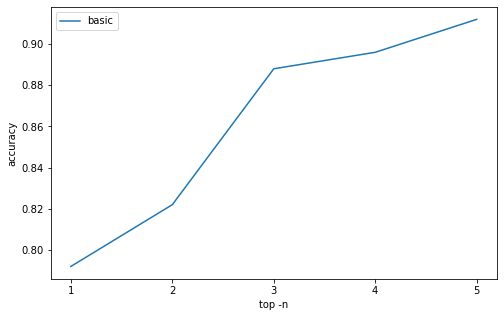

In [21]:
plot_accuracy(dic_fusion, 5)

ceci est l'accuracy obtenu pour la méthode de fusion basic avec l'encoder MiniLM-L-4-v2

In [22]:
accuracy_list = evaluate_model(combined_model, X_question_train['question'], y_train,iteration= 5, batch_size = 100,
                              params = {'method': 'score'})
dic_fusion['score'] = accuracy_list

batch 1 : accuracy top 1 = 0.78
batch 2 : accuracy top 1 = 0.82
batch 3 : accuracy top 1 = 0.85
batch 4 : accuracy top 1 = 0.8
batch 5 : accuracy top 1 = 0.85


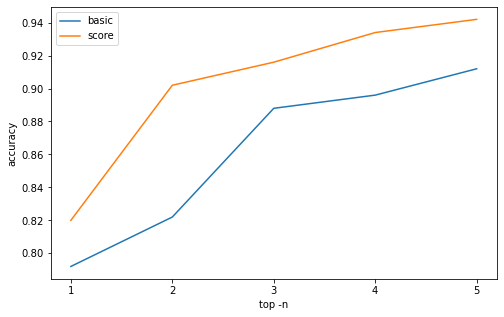

In [23]:
plot_accuracy(dic_fusion, 5)

In [24]:
accuracy_list = evaluate_model(combined_model, X_question_train['question'], y_train,iteration= 5, batch_size = 100,
                              params = {'method': 'rep'})
dic_fusion['rep'] = accuracy_list

batch 1 : accuracy top 1 = 0.83
batch 2 : accuracy top 1 = 0.85
batch 3 : accuracy top 1 = 0.81
batch 4 : accuracy top 1 = 0.89
batch 5 : accuracy top 1 = 0.8


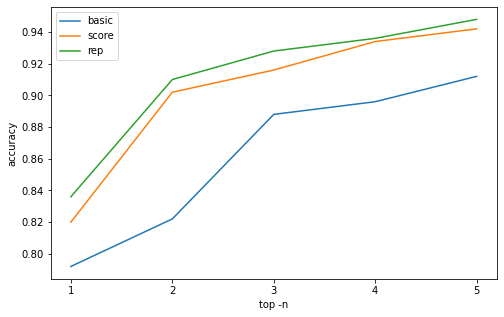

In [25]:
plot_accuracy(dic_fusion, 5)

In [30]:
combined_model1 = Combined_model(context_id,X_context_train['text_context'], model1_params, model3_params, 5)
combined_model1.fit()

In [31]:
accuracy_list = evaluate_model(combined_model1, X_question_train['question'], y_train,iteration= 5, batch_size = 100,
                              params = {'method': 'rep'})
dic_fusion['tfidf-bm25 with rep'] = accuracy_list

batch 1 : accuracy top 1 = 0.83
batch 2 : accuracy top 1 = 0.83
batch 3 : accuracy top 1 = 0.8
batch 4 : accuracy top 1 = 0.81
batch 5 : accuracy top 1 = 0.76


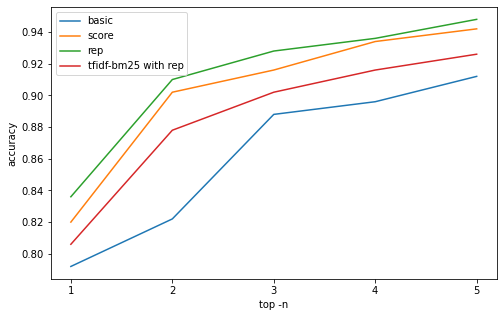

In [32]:
plot_accuracy(dic_fusion, 5)

On observe bien que notre intuition de conserver un équilibre entre les models lors de la fusion sans répétition fonctionne.
nous avons aussi observé les performances du model combiné tfidf-bm25 avec la méthode rep. ses performances sont moins bonnes que la combinaison tfidf-transformer avec la méthode rep

#### c. le model final
Notre model final est donc construit de la manière suivante:  
- on détermine les 20 documents les plus pertinents avec **TF-IDF**
- on determine les 20 documents les plus pertinents avec **SentenceTransformer('all-MiniLM-L6-v2')**
- on fusion en prenant les 10 meilleurs documents de SentenceTransformer, puis les 10 meilleurs de TF-IDF qui ne sont pas encore sélectionnés
- on choisit le meilleur parmi les 20 à l'aide du crossencoder **cross-encoder/ms-marco-MiniLM-L-4-v2** 

## 5. Evaluation du model final sur le val_set

In [54]:
dic_val = {}

In [51]:
X_question_val = pd.read_csv('Data/val_data/val_questions.csv')
X_context_val = pd.read_csv('Data/val_data/val_contexts.csv')
context_embedding = read_context_embedding('Data/val_data/val_context_embbeding_with_bert.csv')
y_val = X_question_val['id_context']
context_id = X_context_val.index

In [52]:
combined_model = Combined_model(context_id,X_context_val['text_context'], model1_params, model2_params, 5)
combined_model.fit()

In [55]:
accuracy_list = evaluate_model(combined_model, X_question_val['question'], y_val,iteration= 5, batch_size = 100,
                              params = {'method': 'rep'})
dic_val['val'] = accuracy_list

batch 1 : accuracy top 1 = 0.86
batch 2 : accuracy top 1 = 0.89
batch 3 : accuracy top 1 = 0.85
batch 4 : accuracy top 1 = 0.85
batch 5 : accuracy top 1 = 0.9


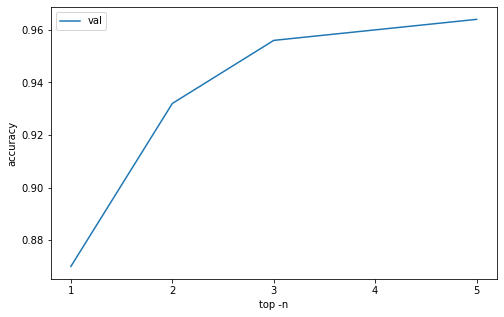

In [56]:
plot_accuracy(dic_val, 5)

In [65]:
print("accuracy top 1 du model sur le test set est d'environs " + "{:.2f}".format(dic_val['val'][0]))

accuracy top 1 du model sur le test set est d'environs 0.87
